# Exploratory Data Analysis

This notebook performs quick checks on:
- Raw BRATS slices (FLAIR + segmentation mask)
- Raw ACDC DICOM slices
- Processed `(coords, vals)` arrays (e.g. reconstructing a slice from coords/vals)
- Class distributions and basic shapes

**Prerequisites**:  
- `data/Raw/BRATS2021/...` folders with `FLAIR.nii.gz` and `segmentation.nii.gz`  
- `data/Raw/ACDC/...` folders with `.dcm` files and `labels.json`  
- `data/Processed/BRATS_Subset/` and `data/Processed/ACDC_Subset/` already generated  
- Installed packages: `nibabel`, `pydicom`, `matplotlib`, `numpy`


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pydicom

# Paths (adjust if needed)
BRATS_RAW = r"D:\Emin\PythonProjects\lfd_project\data\Raw\BRATS2021"
ACDC_RAW = r"D:\Emin\PythonProjects\lfd_project\data\Raw\ACDC"
BRATS_PROC = r"D:\Emin\PythonProjects\lfd_project\data\Processed\BRATS_Subset"
ACDC_PROC = r"D:\Emin\PythonProjects\lfd_project\data\Processed\ACDC_Subset"


## 1. BRATS: Display Random FLAIR Slice & Segmentation Mask


First few patient folders: ['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006']
Patient BraTS2021_00000 -- 47 tumor slices, 108 no‐tumor slices


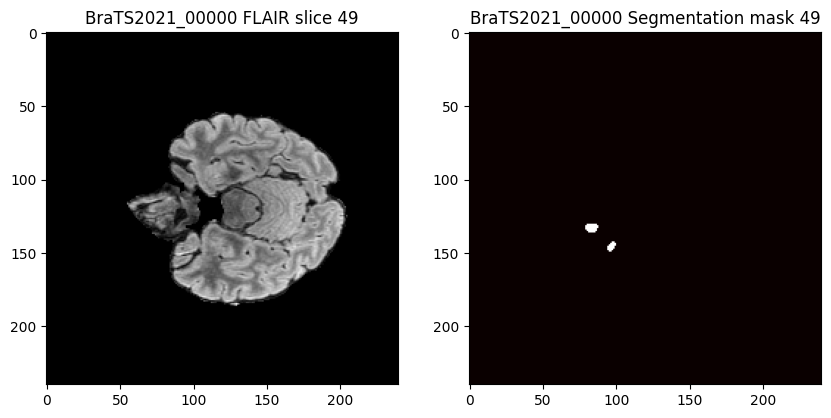

In [6]:
# List a few BRATS patient folders:
patients = sorted(os.listdir(BRATS_RAW))[:5]
print("First few patient folders:", patients)

# Pick one patient that definitely has a tumor and load
sample_patient = patients[0]
flair_path = os.path.join(BRATS_RAW, sample_patient, sample_patient+"_flair.nii.gz")
seg_path = os.path.join(BRATS_RAW, sample_patient, sample_patient+"_seg.nii.gz")

flair_vol = nib.load(flair_path).get_fdata().astype(np.float32)
seg_vol = nib.load(seg_path).get_fdata().astype(np.int16)

H, W, D = flair_vol.shape
# Find tumor slices (mask > 0):
tumor_idxs = [k for k in range(D) if np.any(seg_vol[..., k] > 0)]
non_tumor_idxs = [k for k in range(D) if not np.any(seg_vol[..., k] > 0)]
print(f"Patient {sample_patient} -- {len(tumor_idxs)} tumor slices, {len(non_tumor_idxs)} no‐tumor slices")

# Show first tumor slice and its mask
k0 = tumor_idxs[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(flair_vol[..., k0], cmap="gray")
axes[0].set_title(f"{sample_patient} FLAIR slice {k0}")
axes[1].imshow(seg_vol[..., k0], cmap="hot")
axes[1].set_title(f"{sample_patient} Segmentation mask {k0}")
plt.show()


### 1.1. Reconstruct FLAIR slice from Processed `(coords.npy, vals.npy)`


Example processed file: BraTS2021_00000_slice_049_coords.npy


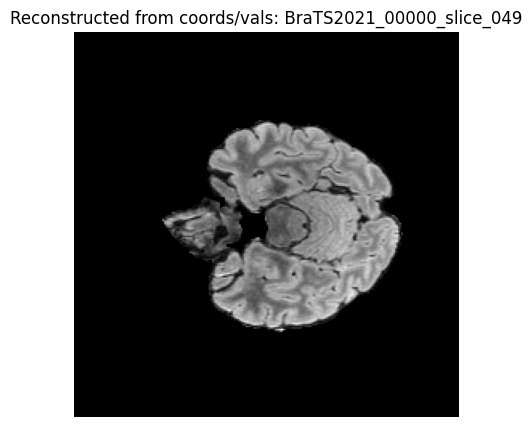

In [7]:
# Find one processed BRATS “Tumor” slice:
tumor_dir = os.path.join(BRATS_PROC, "Tumor")
sample_files = sorted([f for f in os.listdir(tumor_dir) if f.endswith("_coords.npy")])
print("Example processed file:", sample_files[0])

prefix = sample_files[0].replace("_coords.npy", "")
coords = np.load(os.path.join(tumor_dir, prefix + "_coords.npy"))  # shape (H*W,2)
vals = np.load(os.path.join(tumor_dir, prefix + "_vals.npy"))      # shape (H*W,)

# Recover original resolution (we know H and W from flair_vol shape)
H, W = flair_vol.shape[:2]
recon = np.zeros((H, W), dtype=np.float32)
# coords range is [0,1] so i = x*(H-1), j = y*(W-1)
for (x, y), v in zip(coords, vals):
    i = int(round(x * (H - 1)))
    j = int(round(y * (W - 1)))
    recon[i, j] = v

plt.figure(figsize=(5,5))
plt.imshow(recon, cmap="gray")
plt.title(f"Reconstructed from coords/vals: {prefix}")
plt.axis("off")
plt.show()


## 2. ACDC: Show Random DICOM Slice(s)


In [ ]:
# Read labels.json to see patient‐class mapping
import json
labels_json = os.path.join(ACDC_RAW, "labels.json")
with open(labels_json, "r") as f:
    labels_dict = json.load(f)
some_patient, some_cls = next(iter(labels_dict.items()))
print(f"Example patient: {some_patient} -- Class: {some_cls}")

dcm_folder = os.path.join(ACDC_RAW, some_patient)
dcm_files = sorted([f for f in os.listdir(dcm_folder) if f.endswith(".dcm")])
print("Number of DICOM slices:", len(dcm_files))

# Display first 3 slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(min(3, len(dcm_files))):
    ds = pydicom.dcmread(os.path.join(dcm_folder, dcm_files[idx]))
    img = ds.pixel_array.astype(np.float32)
    axes[idx].imshow(img, cmap="gray")
    axes[idx].set_title(f"{some_patient} slice {idx}")
    axes[idx].axis("off")
plt.show()


### 2.1. Reconstruct ACDC slice from `(coords, vals)`


In [ ]:
# Pick one from “NOR” class
nor_dir = os.path.join(ACDC_PROC, "NOR")
proc_files = sorted([f for f in os.listdir(nor_dir) if f.endswith("_coords.npy")])
print("Example processed ACDC file:", proc_files[0])

prefix = proc_files[0].replace("_coords.npy", "")
coords = np.load(os.path.join(nor_dir, prefix + "_coords.npy"))
vals = np.load(os.path.join(nor_dir, prefix + "_vals.npy"))

# Try to infer H, W from one DICOM of that patient
pid = prefix.split("_")[0]
sample_dcm = pydicom.dcmread(os.path.join(ACDC_RAW, pid, os.listdir(os.path.join(ACDC_RAW, pid))[0]))
H, W = sample_dcm.pixel_array.shape

recon = np.zeros((H, W), dtype=np.float32)
for (x, y), v in zip(coords, vals):
    i = int(round(x * (H - 1)))
    j = int(round(y * (W - 1)))
    recon[i, j] = v

plt.figure(figsize=(5,5))
plt.imshow(recon, cmap="gray")
plt.title(f"Reconstructed ACDC: {prefix}")
plt.axis("off")
plt.show()


## 3. Class Distribution in Processed Subsets


In [8]:
# BRATS counts:
for cls in ["Tumor", "NoTumor"]:
    cnt = len([f for f in os.listdir(os.path.join(BRATS_PROC, cls)) if f.endswith("_coords.npy")])
    print(f"BRATS {cls}: {cnt} slices")




BRATS Tumor: 100 slices
BRATS NoTumor: 100 slices


In [ ]:
# ACDC counts:
for cls in ["NOR", "DCM", "HCM", "MINF", "RV"]:
    cls_path = os.path.join(ACDC_PROC, cls)
    if os.path.isdir(cls_path):
        cnt = len([f for f in os.listdir(cls_path) if f.endswith("_coords.npy")])
        print(f"ACDC {cls}: {cnt} slices")

## 4. Conclusion

- We have verified that raw volumes and DICOMs load correctly.
- Processed `(coords, vals)` arrays can reconstruct original slices without visible artifacts.
- Class counts match our expectations: 100 tumor/100 no‐tumor in BRATS; 40 per class in ACDC.

Next steps: train INRs on these slices and examine theta‐space clustering.
